# Assessment and comparison of models

## Summary

ResPr-UNet-3D-Denoising-Efficient-Pipeline-TF-keras repository. This repository contains data, code and results for the paper, A residual U-Net network with image prior for 3D image denoising, Proc. Eur. Signal Process. Conf. EUSIPCO, pp. 1264-1268, 2020. (hal-02500664)  
   
Notebook for assessing and comparing 2D and 3D learning models to variational approaches for denoising. See Train_model_denoising2D.ipynb, Train_model_denoising2D.py, Train_model_denoising3D.py. 

Data obtained from kits19 CT thorax data set ([kits19](https://kits19.grand-challenge.org/)).

## Notebook settings

Demand GPU on Edit/Notebook settings.

### Mount google drive and paths

Start by mounting your google drive:   

In [2]:
# Mount google drive to access files via colab
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


## Define requirements and parameters

Requirements:

In [3]:
# Requirements
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd

print(tf.__version__)

2.5.0


Define function for simpler display 

In [4]:
# Display raw and noise images
def display_grid(plot_data, plot_titles, figsize=(6,6), nameSave = []):
# plot_data : list of images
# plot_titles: list of titles
    num_imgs = len(plot_data)
    num_cols = int(np.ceil(np.sqrt(num_imgs)))
    fig = plt.figure(figsize=figsize)
    for i in range(num_imgs):
        # Start next subplot.
        plt.subplot(num_cols, num_cols, i + 1, title=plot_titles[i])
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(plot_data[i], cmap='gray', vmin=0, vmax=1)
    if nameSave:
        fig.savefig(nameSave, dpi = 300, bbox_inches='tight') 
    return fig

In [5]:
# IMAGE PARAMETERS
input_shape = (32, 256, 256, 1)
img_depth, img_width, img_height, img_channels = input_shape

# Additive Gaussian noise
perc_noise      = 0.1 

# Data augmentation
#
# central crop before applying random crop
central_fraction = 0.8   

## Data and models

Define the path of the current notebook, something like /content/gdrive/MyDrive/Colab_Notebooks/3D_denosing/

In [6]:
# path_main = os.getcwd()
path_notebook = "/content/gdrive/MyDrive/Colab_Notebooks/3D_denosing"
os.chdir(path_notebook)

print('Current directory: ' + os.getcwd())

Current directory: /content/gdrive/MyDrive/Colab_Notebooks/3D_denosing


Fetch the data and trained models running the following code, or download it from the link provided and modify paths as needed. 

In [ ]:
# Fetch data and models
!wget -O data_models_denoising_comparison.zip 'https://www.dropbox.com/s/occmmmvpsttby26/data_models_denoising_comparison.zip?dl=0'

# Unzip into a directory on the notebook directory
!unzip data_models_denoising_comparison.zip
!rm data_models_denoising_comparison.zip

In [9]:
# Data path
path_data = os.path.join(path_notebook, '3D_denoising')
# path_data = "/content/gdrive/MyDrive/Colab_Notebooks/Data/3D_denoising"

# Models path
path_models = path_data

Load test data set: CT thorax perturbated with 10% additive Gaussian noise. 

Trained models are the following:
* CNN2: 2 32-feature layers, 10k parameters.
* CNN7: (4x32, 4x64, 1x128) 300k parameters, with same size as the 2D-U-Net.
* 2D U-Net: 300k parameters.
* 3D-U-Net: 1M parameters. 

In [10]:
# Name data set 
name_data_test = "kits19_3D_eval_data_4subj_10pcnoise_crop_rnd.npz"

# Models file names
name_models = [
              'kits19_200subj_256x256_test_Convnet2_32_noisepc10_model_best.h5',
              'kits19_200subj_256x256_test_Convnet7_32_noisepc10_model_best.h5',
              'kits19_200subj_256x256_test_UNet_32_noisepc10_model_best.h5',
              'kits19_50subj_256x256_3DUNet_32_noisepc10_model_best.h5'
              ]
model_types = 3*['2D']+['3D']
name_models_title = ['CNN2', 'CNN7', 'U-Net', '3DU-Net']

# Path for results 
#path_results    = os.path.join(path_notebook, "Results")
path_results = "/content/gdrive/MyDrive/Colab_Notebooks/Data/3D_denoising"

if os.path.exists(path_results) is False:
    os.mkdir(path_results)
    print('Subdirectory created for results: ' + path_results)

Load and display data:

In [11]:
# Load data
data = np.load(os.path.join(path_data, name_data_test))

data_test = data['data_test']
data_test_noisy = data['data_test_noisy']

Data size (subjects, batch, nx, ny): (4, 32, 256, 256, 1)


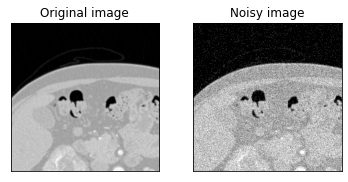

In [12]:
# Display images
print('Data size (subjects, batch, nx, ny): {}'.format(np.shape(data_test)))

for i in range(1):
  fig = display_grid([data_test[i,0,:,:,0], data_test_noisy[i,0,:,:,0]], 
                    ['Original image', 'Noisy image'], figsize=(6,6))


## Assessment of models

Load and assess the models:

In [40]:
# LOAD MODEL AND ASSESS
data_pred_err_all = []
data_pred_ssim_all = []
data_pred_all = []
ind_z = 0 # index for displaying results
for i, (name_model, model_type) in enumerate(zip(name_models,model_types)):
    # Load and predict    
    model = keras.models.load_model(os.path.join(path_models, name_model))#,
                                   # custom_objects=custom_objects[i])
    print('Loaded model: ',name_model)                                   
    model.summary()
    
    # Error on one slice only (to compare 2D and 3D)
    if model_type == '2D':
        data_noisy_this = data_test_noisy[:,ind_z,:,:,:]
    else:
        data_noisy_this = data_test_noisy
    
    data_test_this = data_test[:,ind_z,:,:,:]
        
    data_pred = model.predict(data_noisy_this)
    data_pred_all.append(data_pred)
    
    if model_type == '3D':
      data_pred_this = data_pred[:,ind_z,:,:,:]
    else:
      data_pred_this = data_pred
        
    # Percentage MSE
    data_tets_norm = np.sqrt(np.sum(np.sum(np.square(data_test_this), axis=2),axis=1))
    data_pred_err = np.sqrt(np.sum(np.sum(np.square(data_test_this-data_pred_this), axis=2),axis=1))
    data_pred_err = 100*np.mean(data_pred_err/data_tets_norm)
    data_pred_err_all.append(data_pred_err)
    
    # SSIM
    data_pred_ssim = np.mean(tf.image.ssim(data_test_this, data_pred_this,max_val=1)) 
    data_pred_ssim_all.append(data_pred_ssim)

    print('Perc. MSE: %.2f, SSIM: %.4f' % (data_pred_err, data_pred_ssim))


Loaded model:  kits19_200subj_256x256_test_Convnet2_32_noisepc10_model_best.h5
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 32)      9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 1)       33        
Total params: 9,601
Trainable params: 9,601
Non-trainable params: 0
_________________________________________________________________
Perc. MSE: 4.12, SSIM: 0.7253
Loaded model:  kits19_200subj_256x256_test_Convnet7_32_noisepc10_model_best.h5
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256

In [41]:
# Metrics
metrics = pd.DataFrame({'Perc. MSE': data_pred_err_all, 'SSIM': data_pred_ssim_all})
metrics.index = name_models_title
print(metrics)
# metrics.plot.bar()

         Perc. MSE      SSIM
CNN2      4.117925  0.725344
CNN7      3.156667  0.808890
U-Net     3.046414  0.820610
3DU-Net   2.867357  0.858473


Training times and number of epochs:

In [42]:
# Training times
training_times = [7, 46, 37, 25]
number_epochs = [500, 500, 1000, 5000]
np.array((training_times, number_epochs))
pd.DataFrame(np.transpose(np.array((training_times, number_epochs))),
            index=name_models_title, columns=('Time (h)', 'Epochs'))

,Time (h),Epochs
CNN2,7,500
CNN7,46,500
U-Net,37,1000
3DU-Net,25,5000


Pipeline between 2D and 3D models are different, which explains different training epochs for 2D and 3D cases. For 3D, batch size has been reduce and images sizes are different because of reduced random crop for 3D.  

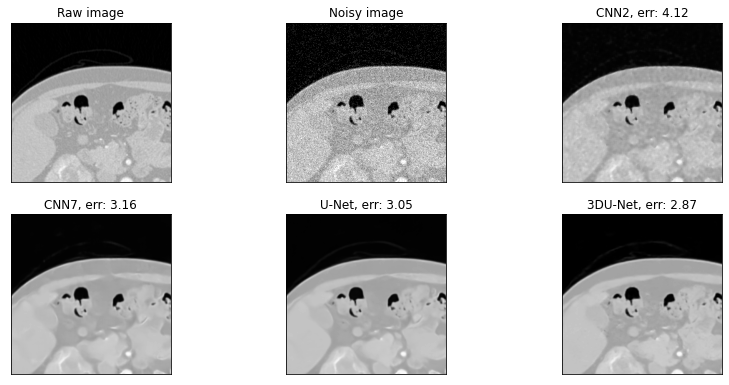

In [43]:
# Display results
#plt.imshow(data_test[7,10,:,:,0], cmap="gray");
plot_data = []
# Indices for dispalying results
ind_batch = 0; #2, 7, 1
ind_z = 0
num_models = len(data_pred_all)
plot_data = [data_test[ind_batch,ind_z,:,:,0],data_test_noisy[ind_batch,ind_z,:,:,0]]
for i, model_type in enumerate(model_types):
    if model_type == '2D':    
        plot_data += [data_pred_all[i][ind_batch,:,:,0]]
    elif model_type == '3D':                                           
        plot_data += [data_pred_all[i][ind_batch,ind_z,:,:,0]]
                                                     
plot_titles = ['Raw image', 'Noisy image']+[
    name_models_title[i]+', err: %.2f' % (data_pred_err_all[i]) 
                                            for i in range(num_models)] 
fig = display_grid(plot_data, plot_titles, figsize=(14,10))
# display_grid(plot_data, plot_titles, figsize=(6,6), nameSave = [])

A slall convnet, CNN2, does not have enough learning power and leads to low image quality, with noisy and blurred results. A larger convnet, CNN7, with same size as the 2D-U-Net, provides high quality results. The 2D U-Net leads to slightly lower errors than CNN7. The 3D-U-Net leads to the lowest error and recovers smaller details, which are not present on the images by the previous methods. 

A 3D-U-Net with higher power (64-feature filters on the first layer and adding scales up to to 256 or 512 filters) could lead to better results for a 3D case. We expect that ResPrUNet would lead to further results (to be tested on these data). 

We also expect iterative deep learning methods to recover further details than the post-processing methods presented here.

## Assess ResPrU-Net

ResPrU-Net has been trained on 5 % noise, so it has not been included in the previous comparison. For 10 % noise, a running average provides whether noisier or more blurred prior image; other methods for estimating the prior image should be used, as an estimate by another network. 

In [70]:
# Load data for 3DResPrUNet : 
name_data_test = 'kits19_2subj_256x256_datafor3DPrResUNet_noisepc5.npz'
data = np.load(os.path.join(path_data, name_data_test))

data_test = data['data_test']
data_test_noisy = data['data_test_noisy']
data_test_prior = data['data_test_prior']

In [51]:
name_model = 'kits19_200subj_256x256_Pr_3DPrResUNet_32_noisepc5_model_best.h5'

model = keras.models.load_model(os.path.join(path_models, name_model))#,
                                   # custom_objects=custom_objects[i])
print('Loaded model: ', name_model)                                   
model.summary()

Loaded model:  kits19_200subj_256x256_Pr_3DPrResUNet_32_noisepc5_model_best.h5
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 32, 256, 256 0                                            
__________________________________________________________________________________________________
input_pr (InputLayer)           [(None, 32, 256, 256 0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 32, 256, 256, 0           input_img[0][0]                  
                                                                 input_pr[0][0]                   
__________________________________________________________________________________________________
conv3d (

Compute the prior image from noisy data.

In [44]:
# Running average on stack with a number of neighbors of stack_size_prior
stack_size_prior = 10
def compute_prior(img_noisy, stack_size=stack_size_prior, decay=tf.constant(0.04,dtype=tf.float32)):
    # 
    stack_size_half = int(stack_size/2)
    decay_ind = tf.concat((tf.range(stack_size_half,1,-1),tf.range(1,stack_size_half+1,1)), axis=0)
    weight_values_ref = tf.exp(-decay*tf.cast(decay_ind, dtype=tf.float32))
    N     = img_noisy.shape
    # In order to change the value of a TF-Array, you need to set it Variable (TF flaw)  
    img_prior_list = []
    for i in range(N[0]):
        weight_values = weight_values_ref
        if i > stack_size_half and i <= N[0]-stack_size_half+1:            
            img_stack = img_noisy[i-stack_size_half:i+stack_size_half-1,:,:,:]
        elif i <= stack_size_half:  
            img_stack = img_noisy[:i+stack_size_half-1,:,:,:]
            weight_values = weight_values[stack_size_half-i:]
        elif i > N[0]-stack_size_half+1:  
            img_stack = img_noisy[i-stack_size_half:,:,:,:]
            weight_values = weight_values[:stack_size_half+N[0]-i]
            
        weight_values = weight_values/tf.reduce_sum(weight_values)    
        img_stack = tf.transpose(img_stack, (1,2,3,0))      
        slice_this = tf.tensordot(img_stack, weight_values, axes=[3,0])

        img_prior_list.append(slice_this)

    img_prior = tf.stack(img_prior_list)
            
    return img_prior

In [45]:
data_test_prior = np.zeros_like(data_test_noisy)
num_subjects = data_test_noisy.shape[0]
for i in range(num_subjects):
  data_test_prior[i,:,:,:,:] = compute_prior(data_test_noisy[i,:,:,:,:], stack_size=stack_size_prior)

In [71]:
# Denoise 
data_pred = model.predict((data_test_noisy, data_test_prior))

data_test_this = data_test[:,ind_z,:,:,:]
data_pred_this = data_pred[:,ind_z,:,:,:]

# Percentage MSE
data_tets_norm = np.sqrt(np.sum(np.sum(np.square(data_test_this), axis=2), axis=1))
data_pred_err = np.sqrt(np.sum(np.sum(np.square(data_test_this-data_pred_this), axis=2), axis=1))
data_pred_err = 100*np.mean(data_pred_err/data_tets_norm)

# SSIM
data_pred_ssim = np.mean(tf.image.ssim(data_test_this,data_pred_this,max_val=1)) 

print('Perc. MSE: %.2f, SSIM: %.4f' % (data_pred_err, data_pred_ssim))

Perc. MSE: 3.55, SSIM: 0.7972


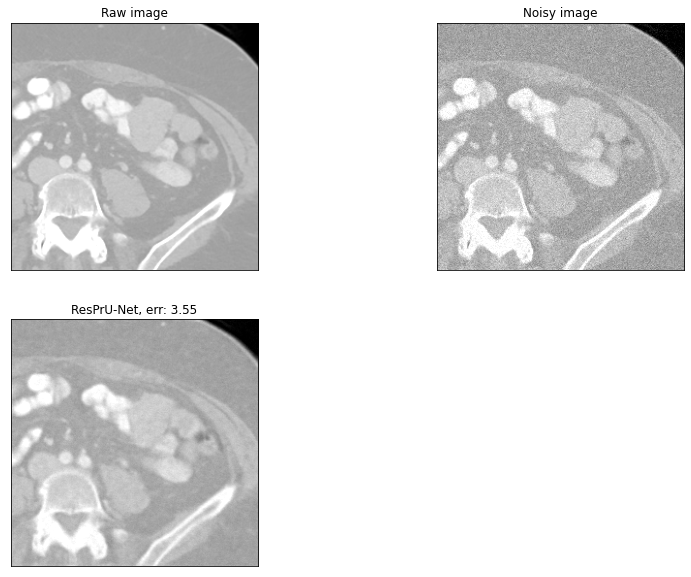

In [75]:
# Display results
name_model_title = ['ResPrU-Net']
plot_data = []
plot_data = [data_test[ind_batch,ind_z,:,:,0],data_test_noisy[ind_batch,ind_z,:,:,0]]
                                        
plot_data += [data_pred[ind_batch,ind_z,:,:,0]]
                                                     
plot_titles = ['Raw image', 'Noisy image']+[
    name_model_title[0]+', err: %.2f' % data_pred_err ] 
fig = display_grid(plot_data, plot_titles, figsize=(14,10))
# display_grid(plot_data, plot_titles, figsize=(6,6), nameSave = [])